### SOLUTION ITK/VTK

(les images sont dans le dossier data)

### Imports

In [10]:
import itk
import vtk
from vtk.util import numpy_support
import numpy as np
import matplotlib.pyplot as plt

### Utils

In [17]:
# Fonction pour lire les fichiers .nrrd
def read_nrrd(file_path):
    reader = itk.ImageFileReader.New(FileName=file_path)
    reader.Update()
    return reader.GetOutput()

# Fonction pour afficher une coupe d'une image ITK
def display_image_slice(image, slice_index, axis=2):
    array = itk.GetArrayFromImage(image)
    if axis == 0:
        slice_ = array[slice_index, :, :]
    elif axis == 1:
        slice_ = array[:, slice_index, :]
    elif axis == 2:
        slice_ = array[:, :, slice_index]
    plt.imshow(slice_, cmap='gray')
    plt.show()
    
def overlay_images(fixed_image, moving_image, slice_index, axis=2):
    fixed_array = itk.GetArrayFromImage(fixed_image)
    moving_array = itk.GetArrayFromImage(moving_image)
    
    if axis == 0:
        fixed_slice = fixed_array[slice_index, :, :]
        moving_slice = moving_array[slice_index, :, :]
    elif axis == 1:
        fixed_slice = fixed_array[:, slice_index, :]
        moving_slice = moving_array[:, slice_index, :]
    elif axis == 2:
        fixed_slice = fixed_array[:, :, slice_index]
        moving_slice = moving_array[:, :, slice_index]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Fixed Image')
    plt.imshow(fixed_slice, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title('Moving Image')
    plt.imshow(moving_slice, cmap='gray')

    plt.show()

    plt.figure(figsize=(5, 5))
    plt.title('Overlay')
    plt.imshow(fixed_slice, cmap='gray', alpha=0.5)
    plt.imshow(moving_slice, cmap='hot', alpha=0.5)
    plt.show()

### Recalage d'images

In [23]:
# Fonction pour réaliser le recalage rigide
def rigid_registration(fixed_image, moving_image):
    # Définir les types d'images
    PixelType = itk.F
    Dimension = 3
    ImageType = itk.Image[PixelType, Dimension]
    
    # Convertir les images en type float
    fixed_image_f = itk.CastImageFilter[type(fixed_image), ImageType].New(Input=fixed_image)
    moving_image_f = itk.CastImageFilter[type(moving_image), ImageType].New(Input=moving_image)
    fixed_image_f.Update()
    moving_image_f.Update()

    # Initialiser la transformation
    initial_transform = itk.CenteredTransformInitializer[ImageType, ImageType].New(
        Transform=itk.Euler3DTransform.New(),
        FixedImage=fixed_image_f.GetOutput(),
        MovingImage=moving_image_f.GetOutput(),
    )
    initial_transform.InitializeTransform()

    # Configurer la méthode de recalage
    registration = itk.ImageRegistrationMethod[ImageType, ImageType].New(
        FixedImage=fixed_image_f.GetOutput(),
        MovingImage=moving_image_f.GetOutput(),
        InitialTransform=initial_transform,
        Metric=itk.MeanSquaresImageToImageMetric[ImageType, ImageType].New(),
        Optimizer=itk.RegularStepGradientDescentOptimizer.New(
            MaximumStepLength=4.0,
            MinimumStepLength=0.01,
            RelaxationFactor=0.5,
            NumberOfIterations=200,
        ),
        Interpolator=itk.LinearInterpolateImageFunction[ImageType, itk.D].New(),
    )

    # Exécuter le recalage
    registration.Update()

    # Obtenir la transformation finale
    final_transform = registration.GetTransform()

    # Rééchantillonner l'image mobile en utilisant la transformation finale
    resampler = itk.ResampleImageFilter[ImageType, ImageType].New(
        Input=moving_image,
        Transform=final_transform,
        UseReferenceImage=True,
        ReferenceImage=fixed_image,
        Interpolator=itk.LinearInterpolateImageFunction[ImageType, itk.D].New(),
    )
    resampler.Update()

    return resampler.GetOutput()

### Test 

Fixed Image - Slice 50


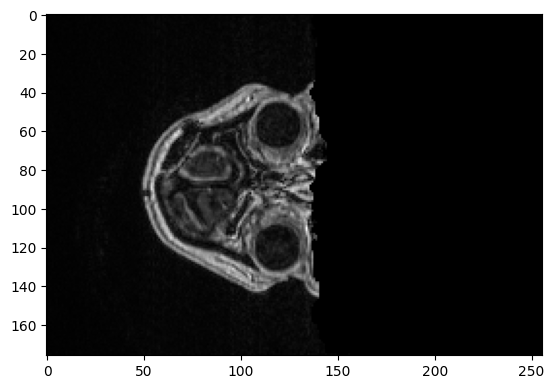

Moving Image - Slice 50


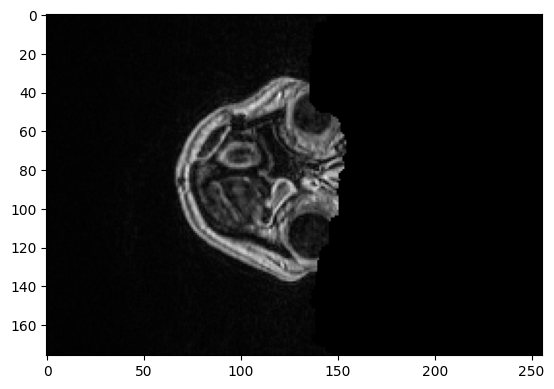

Superposition (sans Recalage)


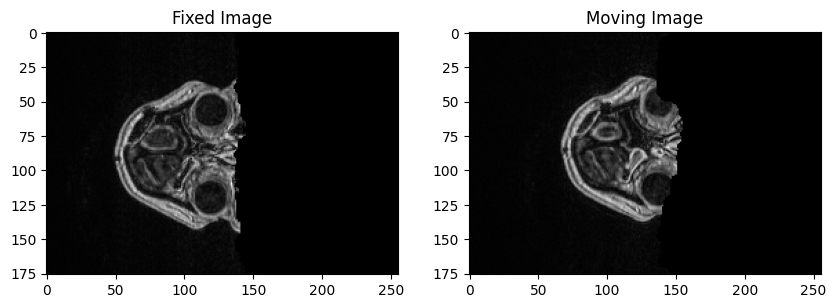

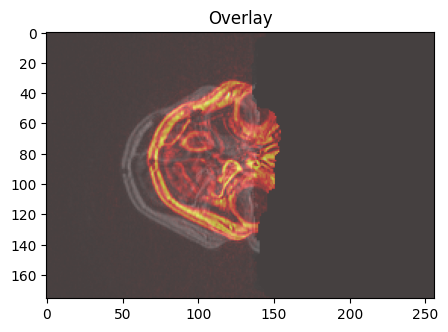

TemplateTypeError: itk.CenteredTransformInitializer is not wrapped for input type `itk.Image[itk.F,3], itk.Image[itk.F,3]`.

To limit the size of the package, only a limited number of
types are available in ITK Python. To print the supported
types, run the following command in your python environment:

    itk.CenteredTransformInitializer.GetTypes()

Possible solutions:
* If you are an application user:
** Convert your input image into a supported format (see below).
** Contact developer to report the issue.
* If you are an application developer, force input images to be
loaded in a supported pixel type.

    e.g.: instance = itk.CenteredTransformInitializer[itk.VersorRigid3DTransform[itk.D], itk.Image[itk.SS,3], itk.Image[itk.SS,3]].New(my_input)

* (Advanced) If you are an application developer, build ITK Python yourself and
turned to `ON` the corresponding CMake option to wrap the pixel type or image
dimension you need. When configuring ITK with CMake, you can set
`ITK_WRAP_${type}` (replace ${type} with appropriate pixel type such as
`double`). If you need to support images with 4 or 5 dimensions, you can add
these dimensions to the list of dimensions in the CMake variable
`ITK_WRAP_IMAGE_DIMS`.

Supported input types:

itk.VersorRigid3DTransform[itk.D]
itk.VersorRigid3DTransform[itk.D]
itk.VersorRigid3DTransform[itk.D]
itk.VersorRigid3DTransform[itk.D]
itk.VersorRigid3DTransform[itk.D]
itk.MatrixOffsetTransformBase[itk.D,2,2]
itk.MatrixOffsetTransformBase[itk.D,2,2]
itk.MatrixOffsetTransformBase[itk.D,2,2]
itk.MatrixOffsetTransformBase[itk.D,2,2]
itk.MatrixOffsetTransformBase[itk.D,2,2]


In [24]:
# Lecture des images
fixed_image_path = '../Data/case6_gre1.nrrd'
moving_image_path = '../Data/case6_gre2.nrrd'

fixed_image = read_nrrd(fixed_image_path)
moving_image = read_nrrd(moving_image_path)

# Affichage des coupes des images avant recalage
print("Fixed Image - Slice 50")
display_image_slice(fixed_image, 50)

print("Moving Image - Slice 50")
display_image_slice(moving_image, 50)

# Superposition des images avant recalage
print("Superposition (sans Recalage)")
overlay_images(fixed_image, moving_image, 50)

# Réalisation du recalage
registered_image = rigid_registration(fixed_image, moving_image)

# Affichage des coupes des images après recalage
print("Registered Image - Slice 50")
display_image_slice(registered_image, 50)

# Superposition des images après recalage
print("Superposition (avec Recalage)")
overlay_images(fixed_image, registered_image, 50)